In [3]:
# libraries
import pandas as pd
import numpy as np

# Read waveform CSV

In [4]:
waveform_data = pd.read_csv('./target_waveform.csv', header=None)
waveform_data

,0,1,2,3,4,5,6,7,8,9,...,2493,2494,2495,2496,2497,2498,2499,2500,2501,2502
0,D0118713C22A5ACF2A023B43E5A330DD,36A5E8E14388ACC5EE03423ABC1B235E,0.514,0.470,0.454,0.442,0.410,0.404,0.452,0.474,...,0.366,0.418,0.418,0.374,0.416,0.382,0.354,0.410,0.448,NaN
1,844AFC179C437B18627CC8B5CC58B1B9,14C015D113EDD99E1338327A185B207F,0.490,0.482,0.444,0.470,0.424,0.394,0.446,0.512,...,0.368,0.412,0.438,0.388,0.398,0.386,0.358,0.378,0.450,NaN
2,CA3EC82E44E9C89448C2E45A007661A0,0A3D1B9795F449F22045E6F4A7962FA5,0.440,0.504,0.458,0.478,0.432,0.404,0.414,0.464,...,0.372,0.352,0.408,0.406,0.360,0.420,0.376,0.348,0.410,NaN
3,819B8CAB5BCA028012133718A905081B,0410AEDD634637368A570914F9CCE661,0.476,0.494,0.454,0.478,0.440,0.392,0.436,0.468,...,0.372,0.366,0.418,0.392,0.368,0.398,0.360,0.350,0.430,NaN
4,0D350F158F8A3EA1F5FBF064DF111799,7B914986DA10EE675B569AF14FEDF7BD,0.482,0.436,0.426,0.424,0.390,0.374,0.440,0.468,...,0.362,0.420,0.408,0.378,0.428,0.378,0.354,0.412,0.452,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,832A2932C24B50B9C980A5E677D7975A,1939176D5CDA3531D973F2704A7D6C4A,0.512,0.486,0.450,0.478,0.440,0.400,0.450,0.516,...,0.372,0.422,0.412,0.390,0.404,0.386,0.346,0.374,0.454,NaN
96,8153F17CA20F93ED214B5D97E62EC20A,352EE6D037299A6906CA6C4C99E4A966,0.462,0.520,0.484,0.494,0.456,0.414,0.434,0.486,...,0.384,0.366,0.416,0.408,0.370,0.408,0.370,0.346,0.424,NaN
97,38B0B4F9B9F0CED9EB9CB0558FBD6985,616F6816354B12FD0FC1F36B783C0C88,0.488,0.448,0.438,0.432,0.406,0.384,0.454,0.476,...,0.364,0.422,0.412,0.382,0.428,0.386,0.352,0.406,0.456,NaN
98,7C7F329624CE00B23F0A05AF0001F3CD,9B0E8BEABD53ECA7E8715EE7348E6F81,0.510,0.504,0.462,0.482,0.434,0.412,0.460,0.506,...,0.366,0.410,0.416,0.380,0.394,0.380,0.350,0.370,0.450,NaN


In [5]:
# for 1 byte, find the corresponding key byte
def get_byte(waveform, rowId, byteId, colId):
    byte_str = "0x" + waveform.iloc[rowId, colId][byteId*2] + waveform.iloc[rowId, colId][byteId*2+1]  # "0x" required
    byte_value = int(byte_str, 16)
    
    return byte_value

def get_plaintext_byte(waveform, rowId, byteId):
    return get_byte(waveform, rowId, byteId, 0)

def get_ciphertext_byte(waveform, rowId, byteId):
    return get_byte(waveform, rowId, byteId, 1)

In [21]:
# get power trace for a time instance (colId)
def get_power_trace(waveform, timeInst, numTraces=100):
    # iloc[row slicing, column slicing]
    return waveform.iloc[0:numTraces, timeInst+2].to_numpy()

In [7]:
#get_plaintext_byte(waveform_data, 0, 0)
get_ciphertext_byte(waveform_data, 0, 1)

165

#### Plot collected power trace

Text(0, 0.5, 'Power consumption')

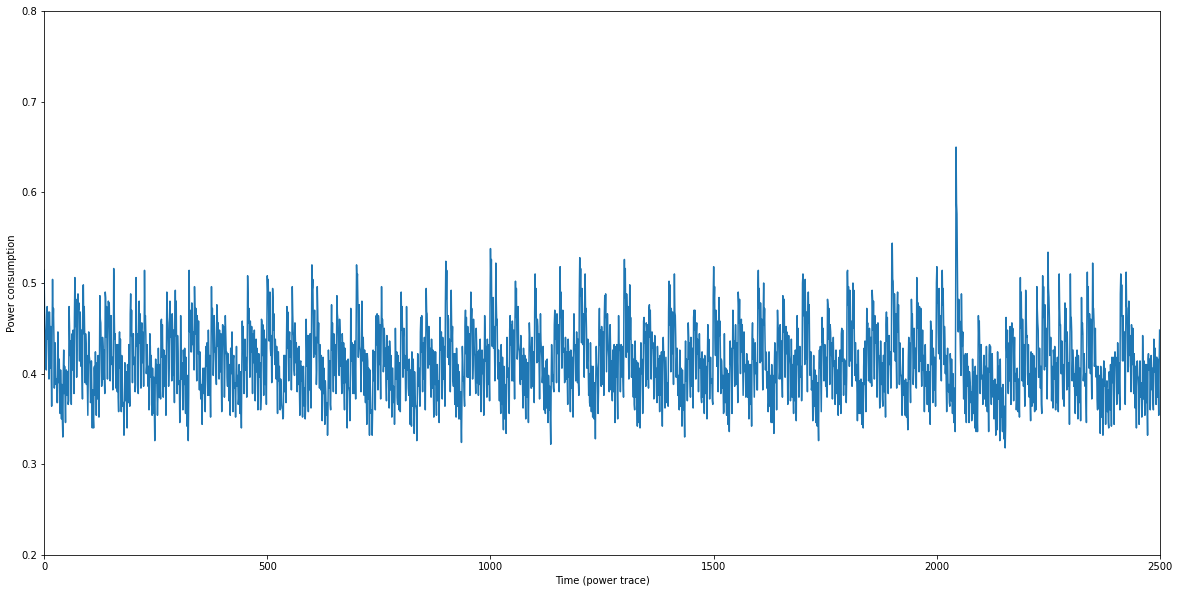

In [8]:
import matplotlib.pyplot as plt
time = list(range(0, 2500))

plt.figure(figsize=(20,10))
plt.axis([0, 2500, 0.2, 0.8])
plt.plot(time, waveform_data.iloc[0, 2:2502].to_numpy())
plt.xlabel('Time (power trace)')
plt.ylabel('Power consumption')

In [9]:
len(get_power_trace(waveform_data, 0))

100

# Correlation Power Analysis (CPA)
Implementation of the algorithm and helper functions for the necessary computations

In [10]:
# for all 256 guesses of K0, calculate Y0 for the different plaintexts
# Y0 = SBOX(A0 XOR K0) (K0 = byte 0 of plaintext XOR byte 0 of key guess)
def calc_Yn(An, Kn):
    return sbox(An ^ Kn)

Sbox = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]


def sbox(val):
    row = int(val/16)
    col = val%16
    return Sbox[row*16 + col]

In [11]:
sbox(0x35)  # 0x96 = 150 (decimal)

150

In [12]:
# model for power consumption
# (the more bits are 0, the more power is consumed)
def power_consump_model(Y):
    return hamming_weight(Y)  # power consumption is proportional to inverse of Hamming Weight

def hamming_weight(val):
    weight = 0
    while val:
        val &= (val - 1)
        weight += 1
    return weight

In [13]:
#hamming_weight(255)  # 8
hamming_weight(3)  # 2

2

#### CPA Algorithm

In [14]:
plaintext_len = 16  # 16 bytes in plaintext/ciphertext
key_guesses = 256  # no. possible guesses for key byte
trace_len = 2500  # no. data points in power trace
num_traces = 100  # no. power traces collected

In [24]:
from tqdm import tqdm  # comment this out if you cannot run tqdm

secret_key = []  # array of bytes uncovered for secret key

# Yi generation loop
for n in tqdm(range(plaintext_len), desc="Plaintext char"):  # each character in plaintext - guess 1 character at a time
#for n in range(plaintext_len):  # use this if tqdm does not work
    
    # get the correlation between power traces at a particular time period, and the power model for a key byte guess
    best_correlations = np.zeros(key_guesses)  # (256x1) correlations, of (256x100) model power traces
    for Kn in range(key_guesses):  # all possible values of a key byte: 0 to 255
        
        # generate power trace model for this key guess (100x1)
        powertrace = np.zeros(num_traces)
        for traceId in range(num_traces):  # each collected power trace (a row in csv)
            An = get_plaintext_byte(waveform_data, traceId, n)
            Yn = calc_Yn(An, Kn)
            powertrace[traceId] = power_consump_model(Yn)
        
        # match power trace model with actual power trace to find correlation
        # calculate the Pearson correlation coefficient
        # best Pearson corrcoeff -> stored in best_correlations[Ki]
        for i in range(trace_len):
            corrcoeff = np.corrcoef(powertrace, get_power_trace(waveform_data, i))[0, 1]
            if abs(corrcoeff) > best_correlations[Kn]:  # should be abs
                best_correlations[Kn] = abs(corrcoeff)
    
    # find the key byte with the best correlation
    max_corrcoeff = best_correlations[0]
    best_Kn = 0
    for i in range(1, key_guesses):
        if best_correlations[i] > max_corrcoeff:
            max_corrcoeff = best_correlations[i]
            best_Kn = i
            
    secret_key.append(best_Kn)
    
print(secret_key)

Plaintext char:   0%|                                                                           | 0/16 [00:02<?, ?it/s]


KeyboardInterrupt: 

# Visualise Correlation Vs Time
When comparing the model power trace to the actual power trace, there will be a moment in the power trace where their correlation is the highest (i.e. where the first SBOX operation is executed).

#### Visualise correlations for a correct key byte

In [15]:
for n in range(1):  # just use first character
    
    # get the correlation between power traces at a particular time period, and the power model for a key byte guess
    correlations = np.zeros(trace_len)  # (256x1) correlations, of (256x100) model power traces
    for Kn in range(87, 88):  # all possible values of a key byte: 0 to 255
        
        # generate power trace model for this key guess (100x1)
        powertrace = np.zeros(num_traces)
        for traceId in range(num_traces):  # each collected power trace (a row in csv)
            An = get_plaintext_byte(waveform_data, traceId, n)
            Yn = calc_Yn(An, Kn)
            powertrace[traceId] = power_consump_model(Yn)
        
        # match power trace model with actual power trace to find correlation
        # calculate the Pearson correlation coefficient
        best_correlation = 0
        for i in range(trace_len):  # over time in the trace
            correlations[i] = np.corrcoef(powertrace, get_power_trace(waveform_data, i))[0, 1]
            if (correlations[i] > best_correlation):
                best_correlation = correlations[i]

0.7074163750301726


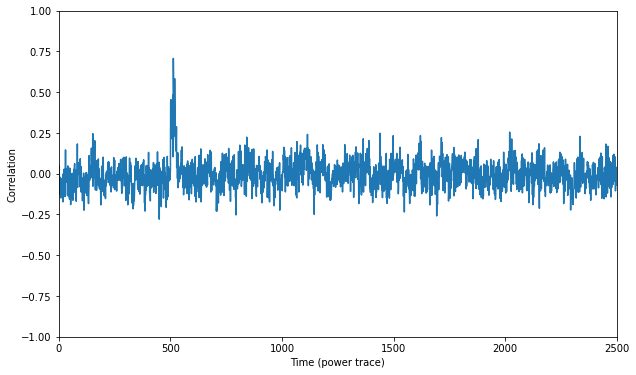

In [18]:
# plot correlations vs time for a correct key byte
import matplotlib.pyplot as plt
time = list(range(0, 2500))

plt.figure(figsize=(10,6))
plt.axis([0, 2500, -1, 1])

plt.plot(time, correlations)
plt.xlabel('Time (power trace)')
plt.ylabel('Correlation')
print(best_correlation)

#### Visualise correlations for an incorrect key byte

In [19]:
for n in range(1):  # just use first character
    
    # get the correlation between power traces at a particular time period, and the power model for a key byte guess
    correlations = np.zeros(trace_len)  # (256x1) correlations, of (256x100) model power traces
    for Kn in range(0, 1):  # all possible values of a key byte: 0 to 255
        
        # generate power trace model for this key guess (100x1)
        powertrace = np.zeros(num_traces)
        for traceId in range(num_traces):  # each collected power trace (a row in csv)
            An = get_plaintext_byte(waveform_data, traceId, n)
            Yn = calc_Yn(An, Kn)
            powertrace[traceId] = power_consump_model(Yn)
        
        # match power trace model with actual power trace to find correlation
        # calculate the Pearson correlation coefficient
        best_correlation = 0
        for i in range(trace_len):
            correlations[i] = np.corrcoef(powertrace, get_power_trace(waveform_data, i))[0, 1]
            if (correlations[i] > best_correlation):
                best_correlation = correlations[i]

0.2986127316258298


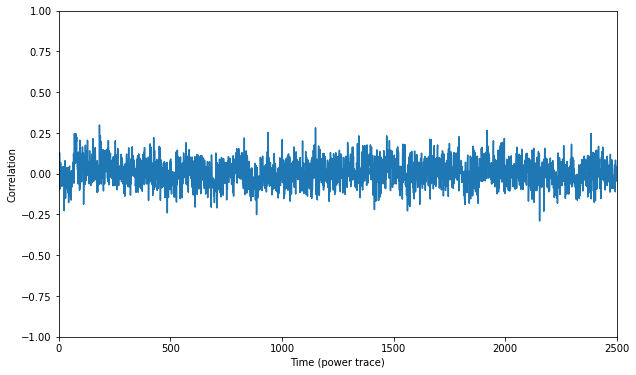

In [21]:
# plot correlations vs time for an incorrect key byte
time = list(range(0, 2500))

plt.figure(figsize=(10,6))
plt.axis([0, 2500, -1, 1])

plt.plot(time, correlations)
plt.xlabel('Time (power trace)')
plt.ylabel('Correlation')
print(best_correlation)

# Experimental Results Plots
1. For 100 traces, plot the correlation of all possible key bytes and highlight the correlation of the correct key byte in red.
2. Plot for "Correlation of the correct key byte vs number of traces". Let the number of traces run from 10 to 100 in steps of 10. This plot need to be shown for all the 16 bytes of the key.

#### Correlation of all possible key bytes (for 100 traces)

In [70]:
plaintext_len = 16  # 16 bytes in plaintext/ciphertext
key_guesses = 256  # no. possible guesses for key byte
trace_len = 2500  # no. data points in power trace
num_traces = 100  # no. power traces collected

Plaintext char:   0%|                                                                            | 0/1 [00:00<?, ?it/s]<ipython-input-69-cef33e9c78f6>:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i,j].set_xticklabels(xlabels);
Plaintext char: 100%|███████████████████████████████████████████████████████████████████| 1/1 [02:18<00:00, 138.13s/it]


[164]


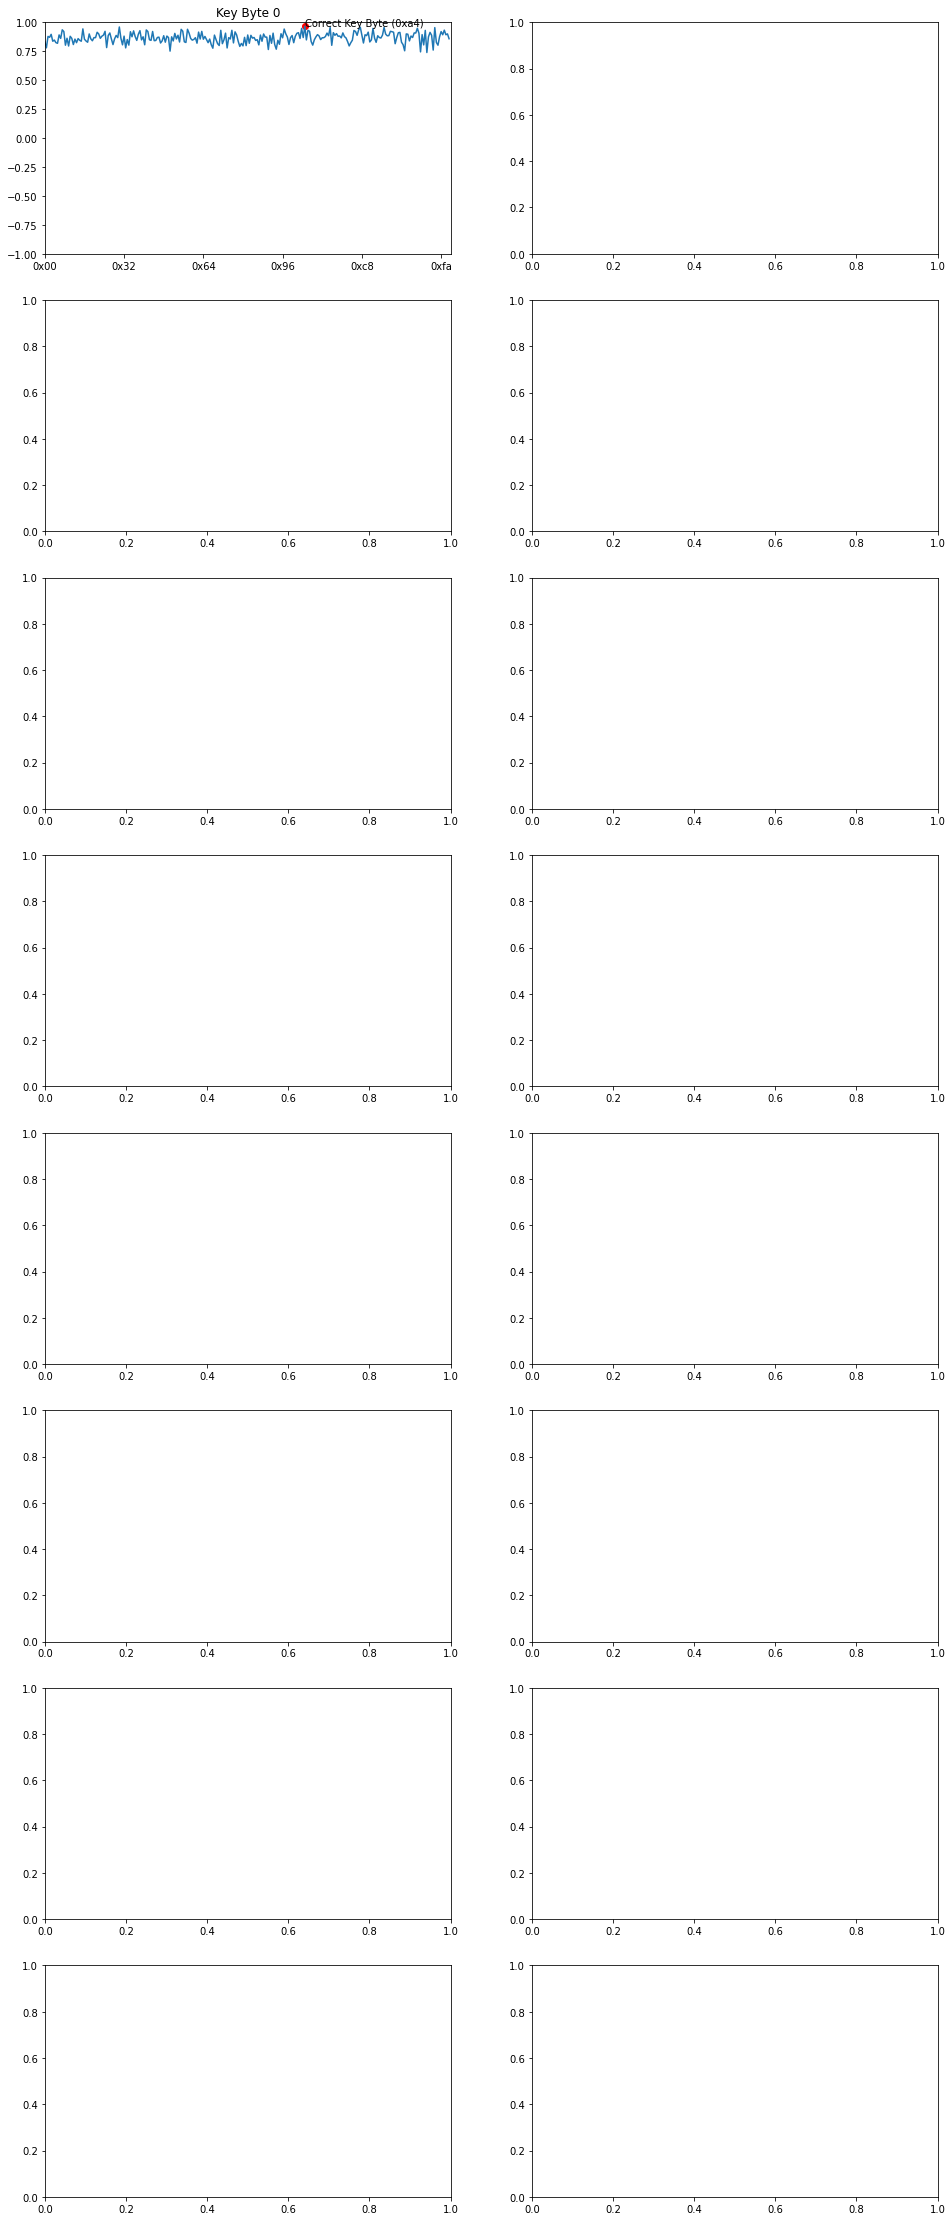

In [69]:
from tqdm import tqdm  # comment this out if you cannot run tqdm
import matplotlib.pyplot as plt

secret_key = []  # array of bytes uncovered for secret key

# for graph
possible_keybytes = list(range(0, key_guesses))  # x-axis
fig, axes = plt.subplots(8, 2, figsize=(16, 40))


# Yi generation loop
for n in tqdm(range(plaintext_len), desc="Plaintext char"):  # each character in plaintext - guess 1 character at a time
#for n in range(plaintext_len):  # use this if tqdm does not work
    
    # get the correlation between power traces at a particular time period, and the power model for a key byte guess
    best_correlations = np.zeros(key_guesses)  # (256x1) correlations, of (256x100) model power traces
    for Kn in range(key_guesses):  # all possible values of a key byte: 0 to 255
        
        # generate power trace model for this key guess (100x1)
        powertrace = np.zeros(num_traces)
        for traceId in range(num_traces):  # each collected power trace (a row in csv)
            An = get_plaintext_byte(waveform_data, traceId, n)
            Yn = calc_Yn(An, Kn)
            powertrace[traceId] = power_consump_model(Yn)
        
        # match power trace model with actual power trace to find correlation
        # calculate the Pearson correlation coefficient
        # best Pearson corrcoeff -> stored in best_correlations[Ki]
        for i in range(trace_len):
            corrcoeff = np.corrcoef(powertrace, get_power_trace(waveform_data, i, num_traces))[0, 1]
            if abs(corrcoeff) > best_correlations[Kn]:  # should be abs
                best_correlations[Kn] = abs(corrcoeff)
    
    # find the key byte with the best correlation
    max_corrcoeff = best_correlations[0]
    best_Kn = 0
    for i in range(1, key_guesses):
        if best_correlations[i] > max_corrcoeff:
            max_corrcoeff = best_correlations[i]
            best_Kn = i
            
    # plot correlations of all possible key bytes
    i = int(n/8)
    j = n%8
    # set axis
    axes[i,j].axis([0, key_guesses, -1, 1])
    xlabels = map(lambda t: '0x%02x' % int(t), axes[i,j].get_xticks())
    axes[i,j].set_xticklabels(xlabels);
    # plot graph
    axes[i,j].set_title('Key Byte ' + str(n))
    axes[i,j].plot(possible_keybytes, best_correlations)
    # annotate the data point of the correct key byte
    axes[i,j].scatter([best_Kn], [max_corrcoeff], color="red")
    axes[i,j].annotate("Correct Key Byte (0x%02x)" % best_Kn, (best_Kn, max_corrcoeff))
    
    # store the secret key
    secret_key.append(best_Kn)
    
print(secret_key)

#### Correlation of the correct key byte vs number of traces (10 to 100, in steps of 10)